<a href="https://colab.research.google.com/github/mr-nudo/neuronModels1/blob/master/syde552_file_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SYDE 552 Assignment 3: Hippocampal Models
### Due Monday, March, Anywhere on Earth
### Value: 15% of total marks for the course

The purpose of this assigment is to give you experience working with associative memories. To do so, we'll be using pytorch to implement different associative memory models.

You can work in groups to do the assignment, but your answers and code must be original to you. Your submission will be a filled-out copy of this notebook (cells for code and written answers provided).

# 1. The Hippocampus

**1.a) [2 marks]** The hippocampus is implicated in spatial navigation and episodic memory.  How do we know this?  What are some of the neuroscience results that revealed these facilities of the hippocampus?  (see Kandel *et al.* Ch. 65)

The case study of H.M, who had bilateral hippocampal damage due to surgery to treat severe epilepsy, provided early evidence for the role of the hippocampus in episodic memory. After the surgery, it was observed that H.M. experienced inability to form new memories, particularly the memory of personal experiences or autobiographical memory.

Furthermore, functional MRI studies have shown that deep encoding tasks, such as attending to the meaning of information, activate regions of the medial temporal lobe, particularly the hippocampus, more strongly than shallow encoding tasks.

Additionally, studies by Anthony Wagner and colleagues using event-related fMRI have demonstrated enhanced activity in the prefrontal cortex during encoding of information that is later successfully recalled. Similarly, greater activity in the medial temporal lobe during encoding is associated with subsequent memory recall, indicating the importance of interaction between prefrontal cortex and medial temporal lobe regions in episodic memory formation.

**1.b) [2 marks]** The Gluck and Meyers model of hippocampus is a simple, effective model of hippocampus, and how representations may be constructed for the slow transfer to the neocortex.  However, it still has its limitations.  Explain some (two or more) of the limitations of the Gluck and Meyers model.  (The Gluck and Meyers Ch.6 reading will be useful in answering this question.)

#### Your answer here

**1.c) [2 mark]** Unsupervised pre-training is integral to the Gluck and Meyers model of Hippocampus, and unsupervised pre-training has been shown to accelerate reinforcement learning in rats navigating mazes.  However, unsupervised pre-training is not common in deep learning techniques.  Describe why that may be.  (See [$\S 15.1$ of Goodfellow *et al.*](https://www.deeplearningbook.org/contents/representation.html))

#### Your answer here

# 2. Hopfield Networks

## Preliminaries

Although you should have installed them for prior assignments, we will require the pytorch and keras. Let's install those now/

```pip install torch keras```

Next, we will download the MNIST dataset.  We will do this through the Keras library instead of torchvision.

Some people have been having problems with the code in the next block due to certificate errors.  If you do have this problem, try using the following code:

```python
import ssl
import keras.datasets.mnist
ssl._create_default_https_context = ssl._create_unverified_context
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
```

I don't recommend doing this if you don't have too - ignoring certificate errors is bad security practice.

In [2]:
!pip install torch keras
import ssl
import keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 738.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 61.5 MB/s eta 0:00:00
11490434/11490434 

As before, we will examine some of the images to make sure we got them right.

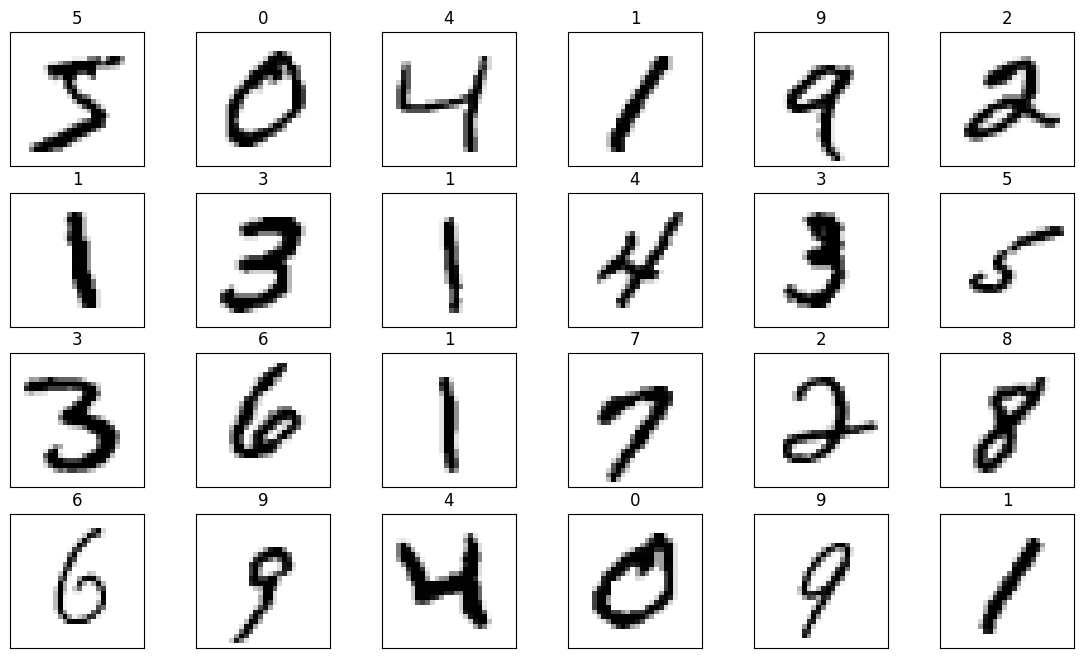

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(14,8))
for i in range(24):
    plt.subplot(4, 6, i+1)
    plt.imshow(x_train[i].reshape((28,28)), vmin=0, vmax=255, cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
    plt.title(int(y_train[i]))

Normally, the MNIST dataset has images represented by values in the range $[0,255]$. However, since we are dealing with Hopfield networks, we are going to binarize the data.

In [4]:
def binarize(xs):
    '''
    xs : a num_samples by num_features array of images.
    '''
    binary = (xs / 255) > 0.5
    integer = 2 * binary - 1
    return integer

binary_imgs = binarize(x_train)


Further, to make things easy on our network, we are only going to look at images of the digits 0, 1, and 2

In [5]:
binary_imgs = binary_imgs[y_train < 3,:]

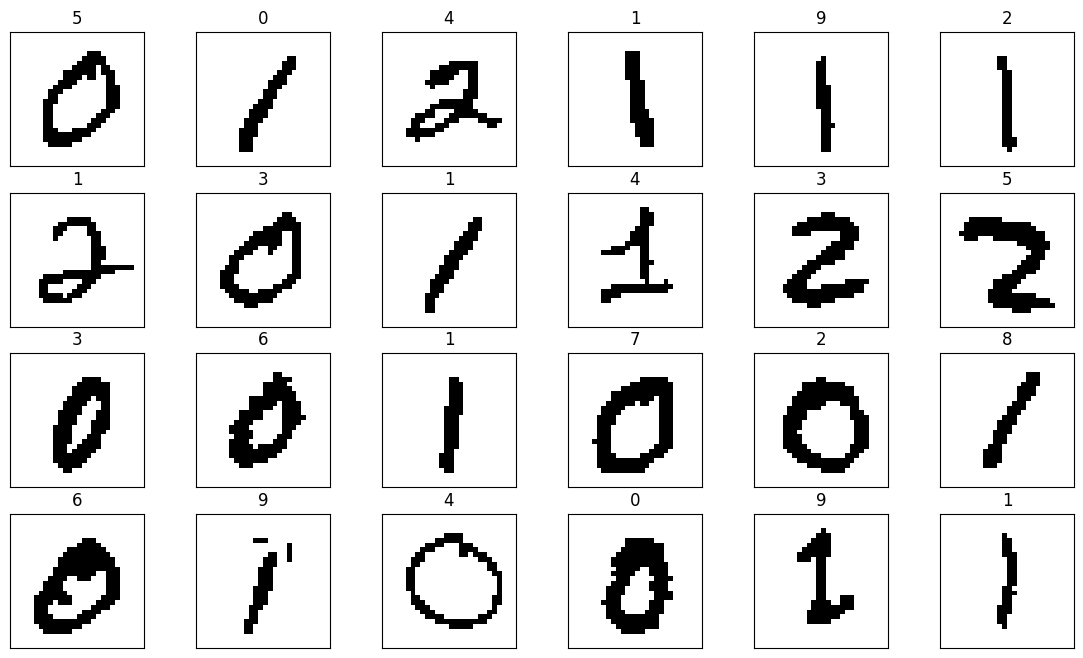

In [6]:
plt.figure(figsize=(14,8))
for i in range(24):
    plt.subplot(4, 6, i+1)
    plt.imshow(binary_imgs[i].reshape((28,28)), vmin=-1, vmax=1, cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
    plt.title(int(y_train[i]))

We will also need to reshape the data into a vector representation, and then covert it to a pytorch tensor

In [8]:
import torch

binary_img_vecs = binary_imgs.reshape((-1,28*28))
binary_img_tensor = torch.from_numpy(binary_img_vecs).to(torch.float32)


**2.a) [2 Marks]**  Implement the Hopfield Network using Hopfield's learning rule.

We will first implement the Hopfield network using the outer product formulation for the weight matrix.  Given a set of patterns $\mathbf{x}_{i}$, by first computing the matrix

$$D = \frac{1}{N}\sum_{i}^{N} (\mathbf{x}_{i}-\theta)(\mathbf{x}_{i}-\theta)^T$$.

where $\theta = \frac{1}{ND}\sum_{i}^{N}\sum_{j}^{D} x_{i,j}$, i.e., the average value of all elements in the training data.

Next we remove the diagonal element of the matrix, making the weight matrix:

$$
W = D - \mathrm{diag}(D),
$$

where $\mathrm{diag}(D)$ is the diagonal of the $D$ matrix.  Note that when implementing this in numpy or pytorch we must apply the ```diag``` function twice, i.e.:

```
W = D - torch.diag(torch.diag(D))

```

Here is some code to implement the learning rule:

In [9]:
import torch
def outer_product_hopfield_matrix(training_patterns):
    '''
    train_hopfield_matrix - produces a matrix for a (non-Modern) Hopfield network using the outer product rule.

    Parameters:
    -----------

    training_patterns : torch.Tensor

        A Tensor of shape (num_patterns, num_features) that will be used to construct the weight matrix.

    Returns:
    --------

    W : torch.Tensor

        A (num_features, num_features) Tensor that stores the papers encoded in the network.
    '''

    theta = torch.sum(training_patterns) / (training_patterns.shape[0] * training_patterns.shape[1])
    D = torch.einsum('nd,ne->de', training_patterns - theta, training_patterns - theta) / float(training_patterns.shape[0])
    W = (D - torch.diag(torch.diag(D)))
    return W

def evaluate_hopfield_network(W, input_pattern, training_patterns=None, num_iters = 5, threshold=0):
    '''
    Evaluates a Hopfield network with weight matrix W on a number of tets patterns.  Also computed the similarity
    '''

    assert input_pattern.shape[1] == 1, f'''This function assumes you are cleaning up one pattern at a time.
                                            Expected the input to be shape (1,{input_pattern.shape[1]}),
                                            got {input_pattern.shape}'''
    s = input_pattern

    similarities = None
    if training_patterns is not None:
        similarities = torch.zeros((num_iters, training_patterns.shape[0]))
    ### end if

    for i in range(num_iters):
        s = torch.sign(W @ s - threshold)

        if training_patterns is not None:
            similarities[i,:] = torch.einsum('d,nd->n',s,training_patterns)
        ### end if
    ### end for
    return s, similarities

We want you to do the following things:

1. Compute the capacity of the network, using the expression $C \approx \frac{d}{2\log_{2}(d)}$, where $d$ is the number of neurons.
2. For a training set of 10 patterns, plot the original image and the reconstructed image side-by-side.
3. Plot the training and test error (Mean squared error between the predicted and true values) of the Hopfield network as a function of the number of patterns stored in the network up to capacity, $C$, for five randomly selected training sets selected from ```binary_img_tensor```.
4. For a training set of size 10 patterns, add salt and pepper noise (bit flips) to the **testing** images and compute the testing error as the probability of noise increases.  Note: Compare the reconstructed images to the non-noisy images, e.g., for any test image you would do something like:

```python
noisy_image = corrupt(test_image, noise_level)
reconstructed_images = evaluate_hopfield_network(W, noisy_image.T)
error = mse(reconstructed_images, test_images)
```

In [16]:
## 2.a.1 - Compute network capacity.
# C = # your code here
d = binary_img_tensor[1]
C = (d / (2 * torch.log2(d))) * d

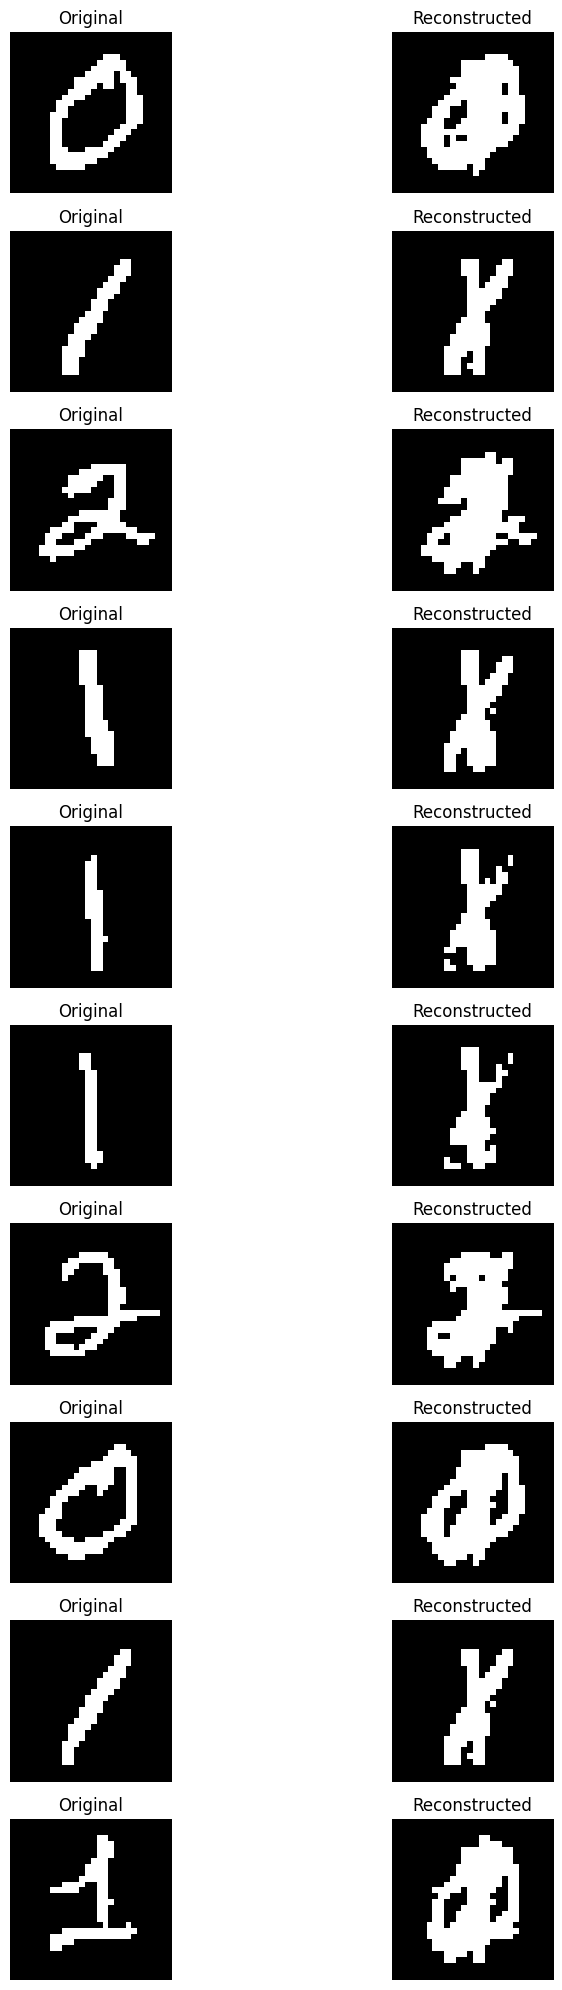

In [21]:
# 2.a.2 - plot original and reconstructed images
plt.figure(figsize=(10, 20))

# create weight matrix, W
W = outer_product_hopfield_matrix(binary_img_tensor[:10])

for i in range(10):
    # reconstruct training image, i
    reconstructed_image = torch.sign(torch.matmul(W, binary_img_tensor[i]))

    plt.subplot(10, 2, 1 + 2 * i)
    # plot original image
    plt.imshow(binary_img_tensor[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')

    plt.subplot(10, 2, 2 + 2 * i)
    # plot reconstructed image
    plt.imshow(reconstructed_image.reshape(28, 28), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [47]:
# 2.a.3 - Plot training and test error

def mse(true_vals, pred_vals):
    return torch.mean((true_vals - pred_vals) ** 2)

def test_network(training_pattens, test_patterns, C):
    assert training_patterns.shape[0] == C, f'''Error: Expected training patterns to contain {C} patterns'''
    training_error = torch.zeros((len(range(2,C)),))
    test_error = torch.zeros((len(range(2,C)),))
    for pattern_idx, num_patterns in enumerate(range(2,C)):
        # train network
        ## NOTE: you will need to change the following line if you want to use something other
        ## than the outer product matrix.
        W = outer_product_hopfield_matrix(training_patterns[:num_patterns,:])
        # for each image in the training set, compute the mse

        training_error_sum = 0
        for test_idx in range(num_patterns):
            reconstructed_train = torch.sign(torch.matmul(W, training_patterns[test_idx]))
            reconstructed_test = torch.sign(torch.matmul(W, test_patterns[test_idx]))

            training_error_sum += mse(training_patterns[test_idx], reconstructed_train)
            test_error_sum += mse(test_patterns[test_idx], reconstructed_test)

        training_error[pattern_idx] = training_error_sum / num_patterns
        test_error[pattern_idx] = test_error_sum / test_patterns.shape[0]

    return training_error, test_error

# Perform tests for 5 randomly selected training sets
# average_results = torch.zeros((5, 2, int(C.item())-2))
average_results = []
for trial in range(5):
    # Randomly select training patterns
    print(binary_img_tensor.shape[0])
    random_indices = torch.randperm(binary_img_tensor.shape[0])[:C[0]]
    training_patterns = binary_img_tensor[random_indices]

    # Generate random test patterns
    test_patterns = torch.randint(0, 2, (100, binary_img_tensor.shape[1])).to(torch.float32) * 2 - 1  # Binary patterns
    test_patterns2 = binarize(binary_img_tensor.shape[1])
    print(test_patterns, test_patterns2)

    # Test network
    training_error, test_error = test_network(training_patterns, test_patterns, C)
    average_results[trial, 0] = training_error
    average_results[trial, 1] = test_error

# Calculate average results across trials
average_results = torch.mean(average_results, dim=0)

# Plot results
plt.figure()
plt.plot(range(2, C), average_results[0], label='Training Error')
plt.plot(range(2, C), average_results[1], label='Test Error')
plt.xlabel('Number of Patterns Stored')
plt.ylabel('Mean Squared Error')
plt.title('Training and Test Error of Hopfield Network')
plt.legend()
plt.show()

18623


TypeError: only integer tensors of a single element can be converted to an index

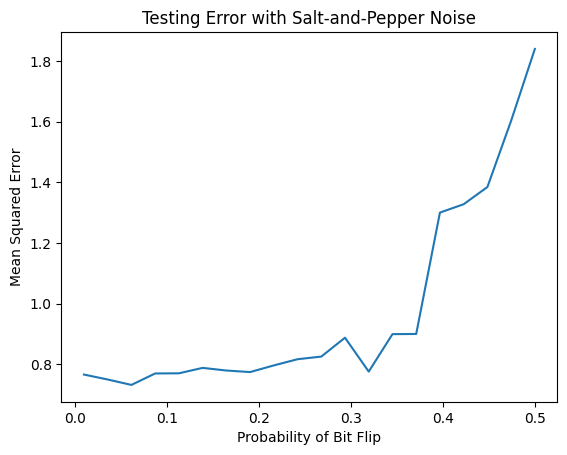

In [48]:
# 2.a.4 - Test salt-and-pepper noise.

# num_steps = None ### Pick a value
# prob_flip = torch.linspace(0.01,0.5,num_steps)

# training_data = # Your code here
# testing_data = # Your code here
# W = # Your code here

# for p_idx, p in enumerate(prob_flip):
#     ## Your code here
#     pass

# plt.figure()
# plt.plot(prob_flip, mses)

# 2.a.4 - Test salt-and-pepper noise.

num_steps = 20  # Pick a value
prob_flip = torch.linspace(0.01, 0.5, num_steps)

# Define corrupted images function
def corrupt(image, noise_level):
    """
    Add salt-and-pepper noise to the image.

    Parameters:
    image : torch.Tensor
        Original image.
    noise_level : float
        Probability of a bit flip (salt or pepper noise).

    Returns:
    torch.Tensor
        Noisy image.
    """
    noisy_image = image.clone()
    num_corruptions = int(noise_level * image.numel())
    idx = torch.randperm(image.numel())[:num_corruptions]
    noisy_image.view(-1)[idx] = 1 - noisy_image.view(-1)[idx]
    return noisy_image

# Initialize list to store MSEs
mses = []

# Generate training data
training_data = binary_img_tensor[:10]

# Generate testing data
testing_data = binary_img_tensor[10000:10010]  # Adjust range as per your requirement

# Calculate weight matrix
W = outer_product_hopfield_matrix(training_data)

# Iterate over different noise levels
for p_idx, p in enumerate(prob_flip):
    total_mse = 0
    # Iterate over testing images
    for test_image in testing_data:
        # Add salt-and-pepper noise
        noisy_image = corrupt(test_image, p)
        # Reconstruct the corrupted image
        reconstructed_image = torch.sign(torch.matmul(W, noisy_image))
        # Compute MSE between the reconstructed image and the original non-noisy image
        mse_value = mse(reconstructed_image, test_image)
        total_mse += mse_value.item()
    # Compute average MSE for the current noise level
    average_mse = total_mse / len(testing_data)
    mses.append(average_mse)

# Plot results
plt.figure()
plt.plot(prob_flip, mses)
plt.xlabel('Probability of Bit Flip')
plt.ylabel('Mean Squared Error')
plt.title('Testing Error with Salt-and-Pepper Noise')
plt.show()

**2.b) [2 Mark]** Train Hopfield network using the pseudo-inverse and repeat the tasks 2.a) 2-4, however, for this example, ensure the threshold value is 0.  Even though the pseudo-inverse has a greater capacity thant he hopfield network, we will still test up to the theoretical capcity of the Hopfield learning rule.

In [ ]:
def pseudo_inv(X, lamb=0.01):
    '''
    pseudo_inv - Implements the pseudoinverse from the previous assignment.

    Parameters:
    -----------

    X : torch.Tensor
        A (num_patterns, num_features) Tensor holding the training data.

    lamb : float
        The regularization term for the pseudoinverse


    Returns:
    --------

    The pseudoinverse of X
    '''
    return torch.inverse(X.T@X + lamb * torch.eye(X.shape[1]).float()) @ X.T

def pseudoinverse_hopfield_matrix(training_patterns, lamb = 0.01):
    '''
    pseudoinverse_hopfield_matrix - Uses the regularized pseudoinverse to construct a weight matrix for
        a non-modern Hopfield network.

    Parameters:
    -----------

    training_patterns : torch.Tensor

        The (num_patterns, num_features) Tensor containing the training data.

    lamb : float

        The regularization term for the pseudo-inverse.

    Returns:
    --------

        The weight matrix compatible with the evaluate_hopfield_network function
    '''
    W = pseudo_inv(training_patterns, lamb=lamb) @ training_patterns
    return W / training_patterns.shape[0]

**2.c) [1 Mark]** Show how the network behaves when an entire region of the image is corrupted.

For your best performing network, take three test images and set half of the inputs to be equal to zero.  
Plot the original images, the corrupted images, and the reconstructed images, side-by-side.

In [ ]:
# Your code here

# 3. Autoencoders

Now we are going to train an autoencoder to perform the same associative task that we explored above.  We are going to define our Autoencoder using sigmoid neurons, which shouldn't be too terrible, since it is a relatively shallow network, but one is not obligated to use those.

Because we are going to use a sigmoidal output function, so we should be concerned with values in the range $[0,1]$, instead of $\{-1,1\}$.  Training will be done using the original MNIST images, **not** the binary images.


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

x_train_tensor = torch.from_numpy(x_train.reshape((-1,28*28)).astype(np.float32) / 255)
x_test_tensor = torch.from_numpy(x_test.reshape((-1,28*28)).astype(np.float32) / 255)

train_dataset = TensorDataset(x_train_tensor, x_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, shuffle=True)

test_dataset = TensorDataset(x_test_tensor, x_test_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=True)

In [ ]:
class Autoencoder(torch.nn.Module):
    def __init__(self, num_inputs, num_hidden):
        super().__init__()

        # Building an linear encoder with Linear
        # layer followed by Sigmoid activation function
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(num_inputs, num_hidden),
            torch.nn.Sigmoid(),
        )

        # Building an linear decoder with Linear
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(num_hidden, num_inputs),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

def continue_training():
    network.train()      # configure the network for training
    for i in range(10):  # train the network 10 times
        epoch_loss = []
        for data, target in train_loader:       # working in batchs of 1000
            optimizer.zero_grad()               # initialize the learning system
            output = network(data)              # feed in the data
            loss = F.mse_loss(output, target)   # compute how wrong the output is
            loss.backward()                     # change the weights to reduce error
            optimizer.step()                    # update the learning rule
            epoch_loss.append(loss.detach().numpy())


    # update the list of training accuracy values
    training_loss.append(np.mean(epoch_loss)) # store the loss for later.
    print('Iteration', len(training_loss), 'Training loss:', training_loss[-1])

    correct = 0
    network.eval()
    test_set_loss = []
    for data, target in test_loader:    # go through the test data once (in groups of 1000)
        output = network(data)                               # feed in the data
        loss = F.mse_loss(output, target)
        test_set_loss.append(loss.detach().numpy())


    # update the list of testing accuracy values
    testing_loss.append(np.mean(test_set_loss))
    print('Iteration', len(testing_loss), 'Testing accuracy:', testing_loss[-1])

**3.1 [2 Marks]** For the autoencoder we will do the following:

1. Train the network and plot the testing and training losses(repeated trials) for 5 different different values of the hidden layer size.  **Ensure the number of hidden layers is always less than the number of input features**.  Select a good number of training iterations (i.e., not overfitting) and a good number of hidden neurons
2. Plot 10 input and reconstructed images from the training set and 10 from the testing set.  How do these compare to the reconstructions of from the Hopfield networks you constructed above?
3. With your trained network, compare the loss on inputs corrupted salt and pepper noise.  Sweep through a range of number of pixels corrupted from 0 to 75\%.  Because the image data is back in the range $[0,1]$, this time corrupt the image by setting pixels to equal 0 or 1 with 50\% probability.

In [ ]:
network = ## Create the autoencoder here

training_loss = []
testing_loss = []

# We're all hip, fashionable people here, let's use the Adam optimizer.
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-1)


**3.2 [1 Mark]** Described what you've observed about the results of the autoencoder, compared to the Hopfield networks.

#### Your answer here

**3.3 [1 Marks]** Sensory Preconditioning - Now we are going to look at small datasets. We are going to use the sensory preconditioning protocol, discussed by Gluck and Meyers.

We will also need to construct a data set that performs the preconditioning.  We will break this down into three phases:

1. Do the sensory preconditioning.  Plot the training loss vs number of epochs, describe the resultant behaviour.

In [ ]:
# Phase 1: Train the network
## features: s1, s2, context1, context2
# we are teaching this network that these inputs only occur to gether, regardless of the context.
stimuli = np.array([[0,0,0,0],
                    [0,0,0,0],
                    [0,0,1,0],
                    [0,0,0,1],
                    [0,0,1,1],
                    [1,1,0,0],
                    [1,1,0,0],
                    [1,1,1,0],
                    [1,1,0,1],
                    [1,1,1,1]]).astype(np.float32)

dataset = TensorDataset(torch.from_numpy(stimuli), torch.from_numpy(stimuli))
data_loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)


epochs = 2000
outputs = []
losses = []

model = Autoencoder(4,3)# Your code here

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-1)
loss_function = torch.nn.BCELoss()


for epoch in range(epochs):
    for (inp, out) in data_loader:

        # Output of Autoencoder
        reconstructed = model(inp)

        # Calculating the loss function
        loss = loss_function(reconstructed, out)

        # The gradients are set to zero,
        # the gradient is computed and stored.
        # .step() performs parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Storing the losses in a list for plotting
        losses.append(loss.detach().numpy())
        pass
    outputs.append((epochs, inp, reconstructed))
    pass

In [ ]:
# Plot loss performance.
# Your code here

2. Train the conditioned response to one stimulus.  We will train this using simple linear regression where we map the the hidden state to the desired output.  You can reuse the linear regression code (```pseudo_inv```) from above.

You will be learning a mapping from the hidden state of the autoencoder to the conditioning stimuli.

Lets call the features (columns) of the stimuli data as s1, s2, c1, and c2.

In [ ]:

conditioning_stimuli = torch.from_numpy(np.array([[0,0,0,0],
                    [0,0,1,0],
                    [0,0,0,1],
                    [0,0,1,1],
                    [1,0,0,0],
                    [1,0,1,0],
                    [1,0,0,1],
                    [1,0,1,1]]).astype(np.float32))
conditioning_outputs = torch.from_numpy(np.array([[0,0,0,0,1,1,1,1]]).astype(np.float32).T)

conditioning_features = model.encoder(conditioning_stimuli)

def get_weights(features, values, lamb=0.01):
    pass # Your code here

def evaluate(weights, features):
    pass # your code here

W = get_weights(conditioning_features, conditioning_outputs)
conditioned_response = evaluate(W, conditioning_features[4:,:])

3. Report the strength of the conditioned response to the other stimulus.  Has the network transferred learning from one stimuls to the other?

In [ ]:
test_stimuli = torch.from_numpy(np.array([
                    [0,1,0,0],
                    [0,1,1,0],
                    [0,1,0,1],
                    [0,1,1,1]]).astype(np.float32))

testing_features = model.encoder(test_stimuli)

transferred_response = evaluate(W, testing_features)


4. Compare to the response of the system without either of the preconditioned inputs

In [ ]:
unconditioned_responses = evaluate(W, conditioning_features[:4,:])

5. Plot graphs showing the strength of the response to the conditioned stimuli, the pre-conditioned stimuli, and the unconditioned stimuli
(*i.e.*, s1 = 0, s2 = 0, and context in $\{(0,0),(0,1),(1,0),(1,1)\}$)

In [ ]:
response_mu = None # Your code here
response_std = None # your code here

ax.bar([1,2,3], response_mu, yerr=response_std, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Conditioned Responses')
ax.set_xticks([1,2,3], labels=['s1+', 's2+', 's1-,s2-'])

**[BONUS]** [1 Mark] Repeat the sensory preconditioning, but use an conditioning stimulus that is not 100\% correlated with the unconditioned stimulus. That is: change phase 2 so that it is not possible to perfectly predict the output.